In [1]:
## basic modules
import os
import sys
import re
import xarray as xr
import glob
import numpy as np
import pandas as pd
import itertools ## need this for the cbarticks
import textwrap
import datetime
import shutil
import subprocess

## plotting modules
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import cmocean
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## personal modules
sys.path.append('../cmap_toolkit') # point this to where you have the CW3E cmaps_toolkit repo located

from plotter import draw_basemap, plot_cw3e_logo, set_cw3e_font
import domains
import cw3ecmaps as ccmaps
from read_deterministic_data import load_GFS_datasets, read_ecmwf_S2D, read_ecmwf_S1D

sys.path.append('../file-reader-toolkit') # point this to where you have the CW3E cmaps_toolkit repo located
import calculations

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
def roundPartial(value, resolution):
    return np.round(value / resolution) * resolution

In [3]:
model_name = 'GFS'
current_lon = 360-120
F = 12

In [4]:
%%time
## 2D dataset with IVT (latitude, longitude)

## vertical cross section along selected longitude
## IVT, IWV, freezing level, surface pressure | single level vars (latitude)
## WV flux, U, and V wind | 2D level (pressure, latitude) vars

s = load_GFS_datasets(F=F, fdate='2024072212')
model_data= s.calc_vars()
model_data

/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
Struct() takes at most 1 argument (3 given)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


CPU times: user 14.8 s, sys: 6.59 s, total: 21.4 s
Wall time: 26.9 s


<xarray.Dataset>
Dimensions:         (latitude: 721, longitude: 1440, pressure: 49)
Coordinates:
  * latitude        (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude       (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * pressure        (pressure) float64 1e+03 975.0 950.0 925.0 ... 3.0 2.0 1.0
Data variables:
    ivt             (latitude, longitude) float64 122.6 122.6 ... 1.416 1.416
    iwv             (latitude, longitude) float32 9.766 9.766 ... 0.7179 0.7179
    sfc_pressure    (latitude, longitude) float32 1.004e+05 ... 7.057e+04
    freezing_level  (latitude, longitude) float32 1.013e+03 ... 1.013e+03
    u               (pressure, latitude, longitude) float32 7.122 ... -10.26
    v               (pressure, latitude, longitude) float32 2.628 ... -33.06
    wvflux          (pressure, latitude, longitude) float64 0.02607 ... 0.0
Attributes:
    model:       GFS
    init:        2024-07-22T12:00:00.000000000
    valid_time:  2024-07-23T00:00:00.000000000
    datacrs:     +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0 +to_meter=11131...

In [5]:
## create list that has the start and end points for the cross section
lon_lst = np.arange(170., 245., 5.)
line_lst = []
for i, lon in enumerate(lon_lst):
    ## create list of lines where [start_lat, start_lon, end_lat, end_lon]
    line = [25., lon, 65., lon]
    line_lst.append(line)
    
print(line_lst)

current_line = [25., current_lon, 65., current_lon]

[[25.0, 170.0, 65.0, 170.0], [25.0, 175.0, 65.0, 175.0], [25.0, 180.0, 65.0, 180.0], [25.0, 185.0, 65.0, 185.0], [25.0, 190.0, 65.0, 190.0], [25.0, 195.0, 65.0, 195.0], [25.0, 200.0, 65.0, 200.0], [25.0, 205.0, 65.0, 205.0], [25.0, 210.0, 65.0, 210.0], [25.0, 215.0, 65.0, 215.0], [25.0, 220.0, 65.0, 220.0], [25.0, 225.0, 65.0, 225.0], [25.0, 230.0, 65.0, 230.0], [25.0, 235.0, 65.0, 235.0], [25.0, 240.0, 65.0, 240.0]]


In [6]:
## subset vertical data and IVT data to current line
cross = model_data.sel(latitude = slice(current_line[2], current_line[0]), longitude=current_line[1])
cross = cross.sortby('latitude')
cross

<xarray.Dataset>
Dimensions:         (latitude: 161, pressure: 49)
Coordinates:
  * latitude        (latitude) float64 25.0 25.25 25.5 25.75 ... 64.5 64.75 65.0
    longitude       float64 240.0
  * pressure        (pressure) float64 1e+03 975.0 950.0 925.0 ... 3.0 2.0 1.0
Data variables:
    ivt             (latitude) float64 43.17 38.2 36.88 ... 87.07 87.69 98.48
    iwv             (latitude) float32 28.88 27.9 27.14 ... 25.94 24.92 25.08
    sfc_pressure    (latitude) float32 1.012e+05 1.012e+05 ... 9.683e+04
    freezing_level  (latitude) float32 538.3 536.9 538.0 ... 634.7 642.3 646.8
    u               (pressure, latitude) float32 -0.07758 -0.1076 ... -15.36
    v               (pressure, latitude) float32 -4.982 -4.832 ... 6.243 7.143
    wvflux          (pressure, latitude) float64 0.05569 0.05385 ... 0.0 0.0
Attributes:
    model:       GFS
    init:        2024-07-22T12:00:00.000000000
    valid_time:  2024-07-23T00:00:00.000000000
    datacrs:     +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0 +to_meter=11131...

In [7]:
## find where IVT >=250 and IWV >=20 for shading
idx = (cross.ivt >=250) & (cross.iwv >=20.)
s = pd.Series(xr.where(idx, True, False))
grp = s.eq(False).cumsum()
arr = grp.loc[s.eq(True)] \
         .groupby(grp) \
         .apply(lambda x: [x.index.min(), x.index.max()])
arr

107    [107, 109]
108    [111, 111]
119    [123, 130]
dtype: object

In [8]:
## Set domain name
domain_name = 'ivtcross'

## Set up data based on domain name
ext = domains.extent[domain_name]['ext']
dx = domains.extent[domain_name]['xticks']
dy = domains.extent[domain_name]['yticks']

datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = domains.extent[domain_name]['ccrs'] ## the projection you want your map displayed in

kw_ticks = {'length': 4, 'width': 0.5, 'pad': 2, 'color': 'black',
            'labelsize': 10, 'labelcolor': 'dimgray'}

kw_ticklabels = {'size': 8, 'color': 'dimgray', 'weight': 'light'}
style = {'size': 7, 'color': 'black', 'fontweight': 'normal'}

In [9]:
## create title label
x = ((current_lon + 180) % 360) - 180
if x > 0:
    lon_lbl = u"{:.0f}\N{DEGREE SIGN}E".format(x)
else:
    lon_lbl = u"{:.0f}\N{DEGREE SIGN}W".format(x*-1)
    
wvflux_units = 'kg m$^{-2}$ s$^{-1}$'
ivt_units = 'kg m$^{-1}$ s$^{-1}$'
wind_units = '(knots)'
title = '{0} IVT ({4}), WV Flux ({1}) and Wind {2} | {3}'.format(model_name, wvflux_units, wind_units, lon_lbl, ivt_units)

init_date = pd.to_datetime(model_data.attrs["init"]).strftime('%H UTC %d %b %Y')
valid_date = pd.to_datetime(model_data.attrs["valid_time"]).strftime('%H UTC %d %b %Y')

left_title = 'Initialized: {0}'.format(init_date)
right_title = 'F-{0} Valid: {1}'.format(str(F).zfill(3), valid_date)

current_dpi=600 #recommended dpi of 600
base_dpi=100
scaling_factor = (current_dpi / base_dpi)**0.13

set_cw3e_font(current_dpi, scaling_factor)

In [10]:
ds = model_data

/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/matplotlib/ticker.py:2920: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/matplotlib/ticker.py:2920: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/matplotlib/ticker.py:2920: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/matplotlib/ticker.py:2920: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


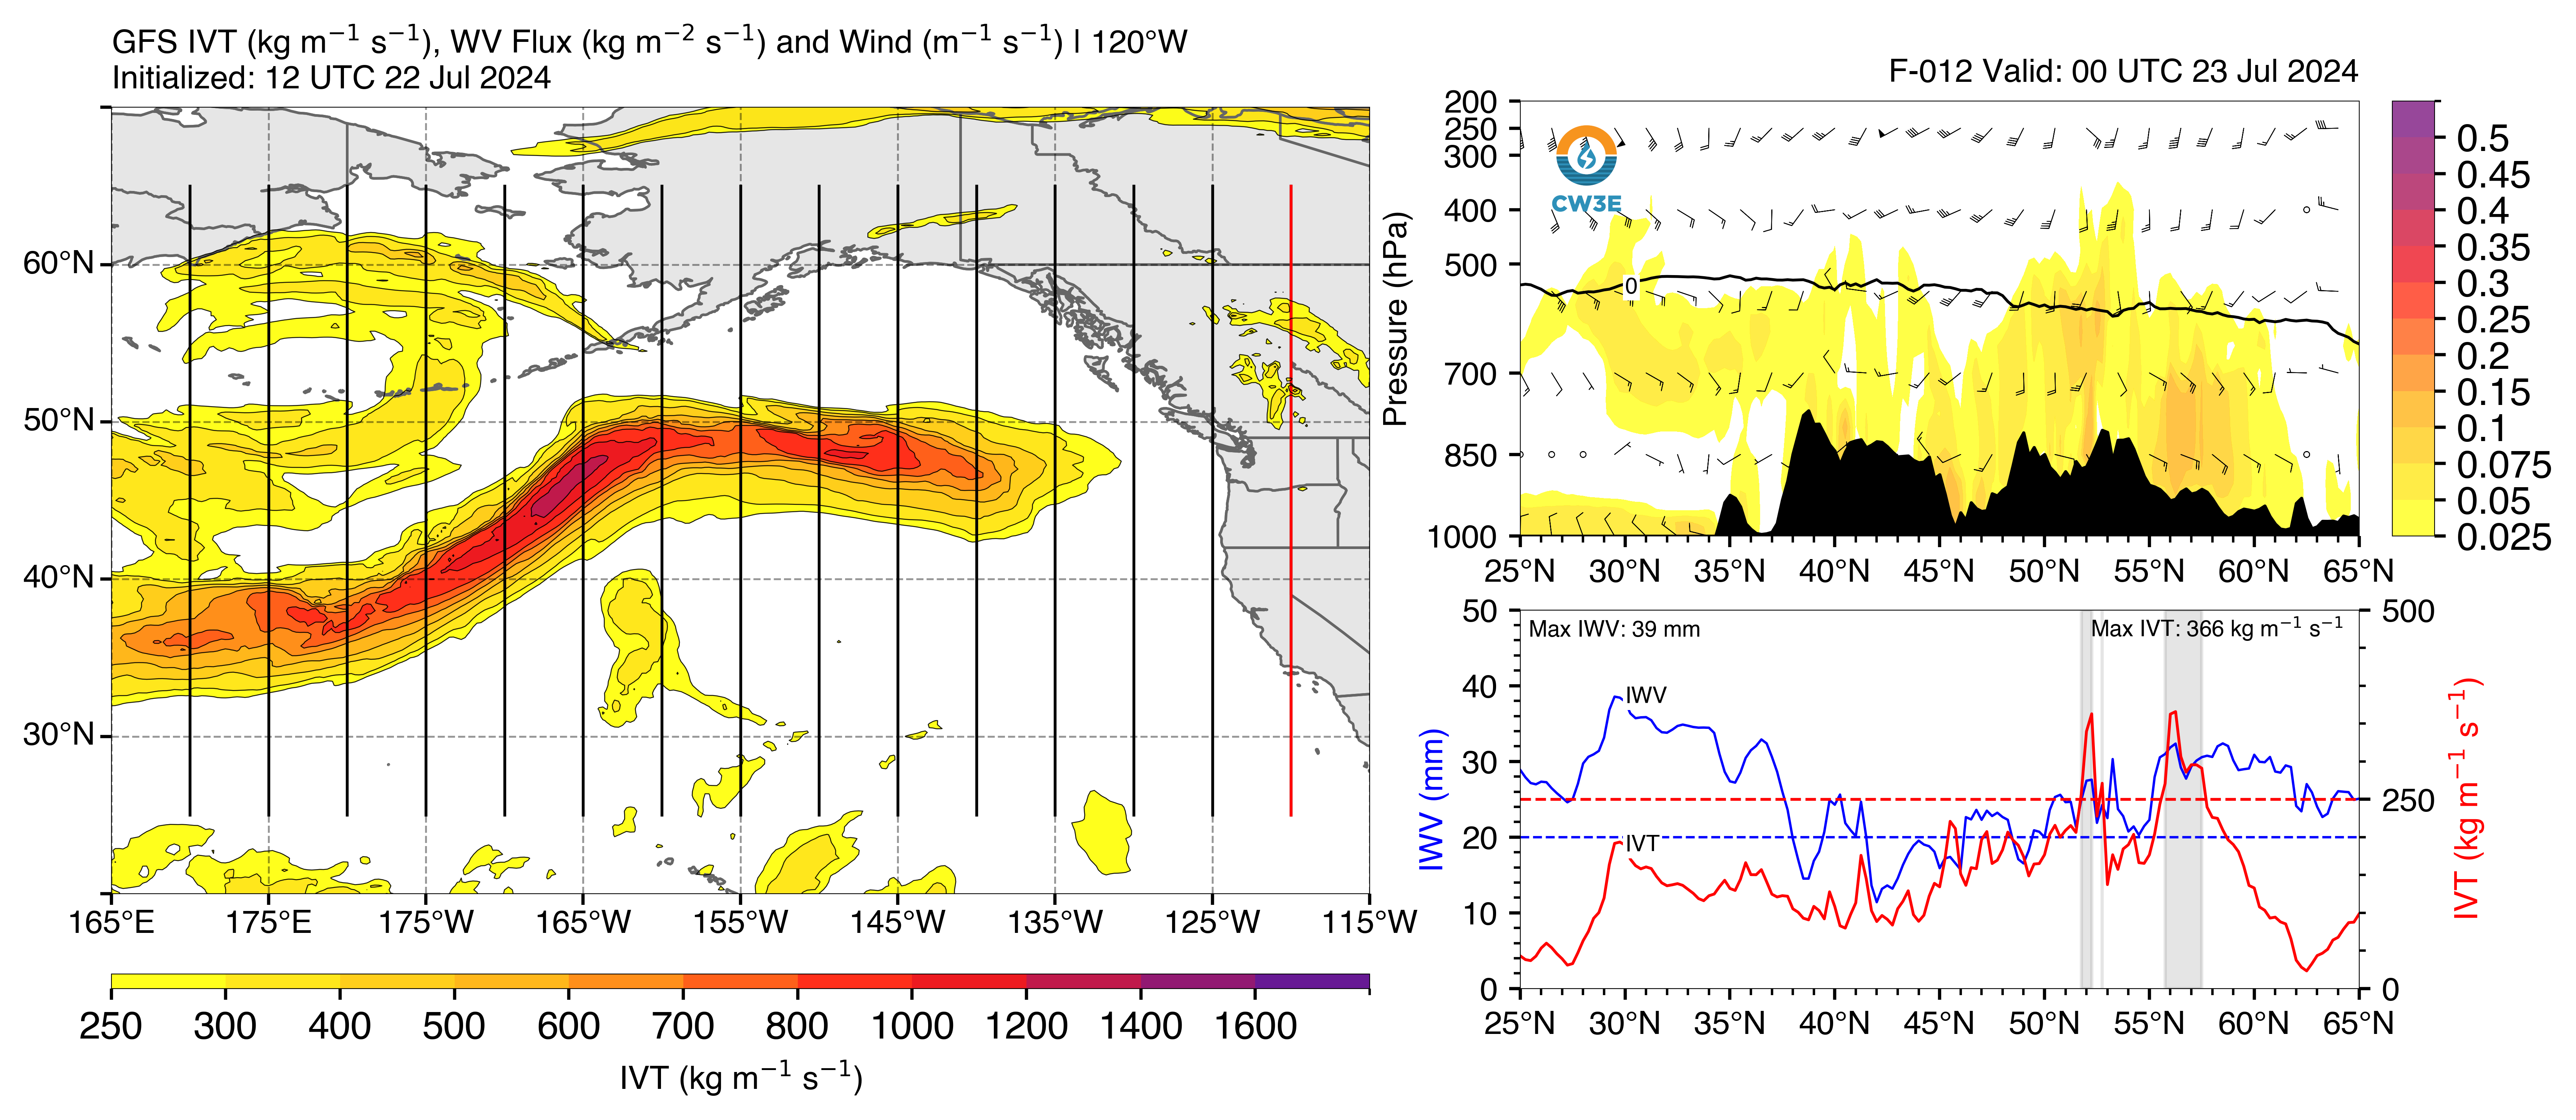

In [11]:
nrows = 3
ncols = 4

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1.5, 1, 0.05], width_ratios = [1.5, 0.1, 1, 0.05], wspace=0.06, hspace=0.3)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(13.0, 5))
fig.dpi = current_dpi
fname = 'test'
fmt = 'png'

####################
### PLOT IVT MAP ###
####################

ax = fig.add_subplot(gs[0:2, 0], projection=mapcrs)
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False, grid=True)
ax.set_extent(ext, datacrs)
ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

## filled contour (IVT)
lats = ds.latitude.values
lons = ds.longitude.values
data = ds.ivt.values
cmap, norm, bnds, cbarticks, cbarlbl = ccmaps.cmap('ivt') # get cmap from our custom function

cf = ax.contourf(lons, lats, data, transform=datacrs, levels=bnds, cmap=cmap, norm=norm, alpha=0.9)

## contour lines (IVT)
cs = ax.contour(lons, lats, data, transform=datacrs, levels=bnds, colors=['black'], linewidths=0.3, alpha=0.9, zorder=100)

## black lines where possible cross sections are
for i, line in enumerate(line_lst):
    ax.plot([line[1], line[3]], [line[0], line[2]], color='k', transform=datacrs, zorder=3)
        
## red line where current cross section is showing
ax.plot([current_line[1], current_line[3]], [current_line[0], current_line[2]], color='r', transform=datacrs, zorder=3)

ax.set_title(title + "\n" + left_title, loc="left")

## color bar
cbax = fig.add_subplot(gs[-1, 0]) # colorbar axis (first row, last column)
cbarticks = list(itertools.compress(bnds, cbarticks)) ## this labels the cbarticks based on the cmap dictionary
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom', ticks=cbarticks)
cb.set_label(cbarlbl)
cb.ax.tick_params(labelsize=12)

#####################
### CROSS SECTION ###
#####################
ax = fig.add_subplot(gs[0, 2])

## y-axis is pressure
## x-axis is latitude

# xs = np.arange(0, len(cross.latitude), 1) # how many coordinate values
xs = cross.latitude.values
ys = cross.pressure.values
terline = cross.sfc_pressure.values / 100. ## convert from Pa to hPa
ht_fill = ax.fill_between(xs, 1000., terline, facecolor='k', edgecolor='k', zorder=10)

# Filled contours (WV flux)
cmap, norm, bnds, cbarticks, cbarlbl = ccmaps.cmap('wvflux') # get cmap from our custom function
cf = ax.contourf(xs, ys, cross.wvflux.values, levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='neither', zorder=-1)
plt.gca().invert_yaxis()
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel("Pressure (hPa)")
ax.set_ylim(1000, 200)
ax.set_yticks([1000., 850., 700., 500., 400., 300., 250., 200.])

## add freezing level
freeze_line = ax.plot(xs, cross.freezing_level, c='k')
ax.annotate('0', xy=(xs[20],cross.freezing_level[20]), xycoords='data',
            textcoords="offset points", # how to position the text
            xytext=(0,-3), # distance from text to points (x,y)
            bbox=dict(boxstyle="square,pad=0.1", fc="white", ec=None, lw=0.0),
            **style)

# wind vectors
dw = 6 # how often to plot vector
ax.barbs(xs[::dw], ys[::dw], cross.u.values[::dw, ::dw]*1.944, cross.v.values[::dw, ::dw]*1.944, 
         linewidth=0.25, length=3.5)

## apply xtick parameters (latitude labels)
ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(xs[0], xs[-1]+1, 5)))
ax.xaxis.set_major_formatter(LATITUDE_FORMATTER)
ax.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=True)
ax.tick_params(axis='x', which='major')

## add titles
ax.set_title(right_title, loc="right")

# # Add color bar
cbax = fig.add_subplot(gs[0, -1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right', ticks=cbarticks)
cb.ax.tick_params(labelsize=12)
cb.ax.set_yticklabels(['{:g}'.format(x) for x in cbarticks]) # force cbartick labels to drop trailing zeros

## Add CW3E logo
in_ax = inset_axes(ax, width="10%", height="20%", loc='upper left')
in_ax = plot_cw3e_logo(in_ax, orientation='vertical')

###################
### TIME SERIES ###
###################
ax = fig.add_subplot(gs[1:, 2])

ax.plot(xs, cross.iwv.values, color='blue', linewidth=0.75)
ax.set_ylabel('IWV (mm)', color='blue')
ax.axhline(y=20.0, color='blue', linestyle='--', linewidth=0.75)
ax.set_xlim(xs[0], xs[-1])

## add IWV label to line
ax.annotate('IWV', xy=(xs[20],cross.iwv[20]), xycoords='data',
            textcoords="offset points", # how to position the text
            xytext=(0,-0.5), # distance from text to points (x,y)
            bbox=dict(boxstyle="square,pad=0.1", fc="white", ec=None, lw=0.0),
            **style)

## set adaptive nice yticks
iwv_max = roundPartial(cross.iwv.max().values+10, 10)
yticks = np.arange(0, iwv_max+10, 10)
ax.yaxis.set_major_locator(mticker.FixedLocator(yticks))
ax.tick_params(axis='y', which='minor', left=True)
ax.set_ylim(yticks[0], yticks[-1])

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(xs, cross.ivt.values, color='red')
ax2.set_ylabel('IVT (kg m$^{-1}$ s$^{-1}$)', color='red')
ax2.axhline(y=250.0, color='red', linestyle='--')
ax2.set_xlim(xs[0], xs[-1])

## add IVT label to line
ax2.annotate('IVT', xy=(xs[20],cross.ivt[20]), xycoords='data',
            textcoords="offset points", # how to position the text
            xytext=(0,-2), # distance from text to points (x,y)
            bbox=dict(boxstyle="square,pad=0.1", fc="white", ec=None, lw=0.0),
            **style)

## set adaptive nice yticks
ivt_max = roundPartial(cross.ivt.max().values+100, 250)
yticks = np.arange(0, ivt_max+100, 250)
ax2.yaxis.set_major_locator(mticker.FixedLocator(yticks))
ax2.minorticks_on()
ax2.tick_params(axis='y', which='minor', right=True)
ax2.set_ylim(yticks[0], yticks[-1])

## apply xtick parameters (latitude labels)
ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(xs[0], xs[-1]+1, 5)))
ax.xaxis.set_major_formatter(LATITUDE_FORMATTER)
ax.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=True)
ax.tick_params(axis='x', which='major')

## add in grey shading where IWV and IVT > thres
for i in range(len(arr)):
    ax.axvspan(xs[arr.iloc[i][0]], xs[arr.iloc[i][1]], color='grey', alpha=0.2, lw=None)
    
## add in annotation of max IWV and IVT vals
IWV_ann = 'Max IWV: {0:0.0f} mm'.format(cross.iwv.max().values)
IVT_ann = 'Max IVT: {0:0.0f} {1}'.format(cross.ivt.max().values, ivt_units)

xy = [(.01, .93), (.68, .93)]
for i, lbl in enumerate([IWV_ann, IVT_ann]):
    ax.annotate(lbl, # this is the text
                xy[i], # these are the coordinates to position the label
                xycoords='axes fraction',
                zorder=200,
                **style)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=False)
plt.show()
fig.clf()